# Creating Provenance an Example Using a Python Notebook

In [205]:
import prov, requests, pandas as pd, io, git, datetime
from prov.model import ProvDocument

## Initialising a Provenance Document

First we use the prov library to create a provenance and initialise it with some relevant namespaces that can be used later to define provenance activities and entities

In [206]:
pg = ProvDocument()

kn_id = "data/data-gov-au/number-of-properties-by-suburb-and-planning-zone-csv"
pg.add_namespace('kn', 'http://oznome.csiro.au/id/')
pg.add_namespace('void', 'http://vocab.deri.ie/void#')
pg.add_namespace('foaf', 'http://xmlns.com/foaf/0.1/')
pg.add_namespace('dc', 'http://purl.org/dc/elements/1.1/')
pg.add_namespace('doap', 'http://usefulinc.com/ns/doap#')



<Namespace: doap {http://usefulinc.com/ns/doap#}>

## Processing the Data

Processing could be anything and represents one or more provenance activities. In this example we use a KN metadata record to retrieve data on residential properities. We intersperse definition of provenance into this processing but we could have easily seperated it out and performed it after the processing steps


First we define an entity that describes the KN metadata records which we are using here

In [207]:
input_identifier = 'kn:'+ kn_id
input_entity = pg.entity(input_identifier, {'prov:label': 'road static parking off street', 'prov:type': 'void:Dataset'})

Then we proceed to drill down to get detailed data that we've found associated with this record

In [208]:
start_time = datetime.datetime.now()

In [209]:
response = requests.get('https://data.sa.gov.au/data/dataset/d080706c-2c05-433d-b84d-9aa9b6ccae73/resource/4a47e89b-4be8-430d-8926-13b180025ac6/download/city-of-onkaparinga---number-of-properties-by-suburb-and-planning-zone-2016.csv')

In [210]:
url_data = response.content

In [211]:
dataframe = pd.read_csv(io.StringIO(url_data.decode('utf-8')))

In [212]:
dataframe.columns

Index(['Suburb', 'Zone', 'Zone_Description', 'Number of Properties'], dtype='object')

Our processing is very simple we are subsetting the original dataset here and creating a new dataset called residential_frame that we will then save to disk

In [213]:
residential_frame = dataframe[dataframe['Zone_Description'] == 'Residential']

In [214]:
residential_frame_file_name = "filtered_residential_data.csv" 
residential_frame.to_csv(residential_frame_file_name)
end_time = datetime.datetime.now()

## Completing Provenance

We have began to build a provenance record but we are missing a record of the activity that transforms our input into the output and we are also missing a description of the output  

### Generating an output provenance entity

Ideally we would store our output provenance entity somewhere known and persistent and identify it with a persistent url. However we can still mint an identifier and then describe the dataset in useful ways that will make it easy to find and query from later. To do this we create a new entity record and use the file name and sha hash of the file to describe it.

In [215]:
import subprocess
output = subprocess.check_output("sha1sum "+ residential_frame_file_name, shell=True)

In [216]:
sha1 = str(output).split(' ')[0][2:]

In [217]:
output_identifier = 'kn:' + sha1
output_entity = pg.entity(output_identifier , {'prov:label': residential_frame_file_name, 'prov:type': 'void:Dataset'})

### Describing the activity 

We need to connect the entity representing the input data to the entity representing the output data and we may want to describe the activity that transforms the input into the output. In this case the activity is this Jupyter Notebook. One way of storing provenance information in it is to make sure it is version controlled in git and then record these details. 

## Connecting things together into the provenance graph

In [218]:
import re, ipykernel, json

In [219]:
%%javascript
var nb = Jupyter.notebook;
var port = window.location.port;
nb.kernel.execute("NB_Port = '" + port + "'");

<IPython.core.display.Javascript object>

In [220]:
kernel_id = re.search('kernel-(.*).json', ipykernel.connect.get_connection_file()).group(1)
response = requests.get('http://127.0.0.1:{port}/jupyter/api/sessions'.format(port=NB_Port))
response.content
matching = [s for s in json.loads(response.text) if s['kernel']['id'] == kernel_id]
if matching:
    matched = matching[0]['notebook']['path']

In [221]:
notebook_file_name = matched.split('/')[-1]

One gotcha here is that we need to make sure this notebooks relevant version has been committed and pushed to the remote. So do that and then execute these cells.

In [222]:
repo = git.Repo('./', search_parent_directories=True)
current_git_sha = repo.head.object.hexsha
current_git_remote = list(repo.remotes['origin'].urls)[0]

In [223]:
current_git_sha

'4ec1d4dedebd46a08a9ef8308b59fe5f17106e44'

In [224]:
current_git_remote

'https://github.com/oznome/jupyter-examples'

In [225]:
activity_identifier =  'kn:' + 'notebook/' +  urllib.parse.quote(notebook_file_name + current_git_sha, safe='')

In [226]:
activity_identifier
activity = pg.activity(activity_identifier, other_attributes={'dc:description': 'a jupyter notebook used that demonstrates provenance', 'doap:GitRepository' : current_git_remote, 'doap:Version' : current_git_sha })

In [227]:
pg.wasGeneratedBy(activity=activity, entity=output_entity)

<ProvGeneration: (kn:0ba7fc1a38498374877df68e41be882923a94596, kn:notebook/Provenance%20using%20KN%20resource.ipynb4ec1d4dedebd46a08a9ef8308b59fe5f17106e44)>

In [228]:
pg.used(activity=activity, entity=input_entity)

<ProvUsage: (kn:notebook/Provenance%20using%20KN%20resource.ipynb4ec1d4dedebd46a08a9ef8308b59fe5f17106e44, kn:data/data-gov-au/number-of-properties-by-suburb-and-planning-zone-csv)>

In [229]:
pg

<ProvDocument>

In [230]:
# visualize the graph
from prov.dot import prov_to_dot
dot = prov_to_dot(pg)
dot.write_png('prov.png')



True

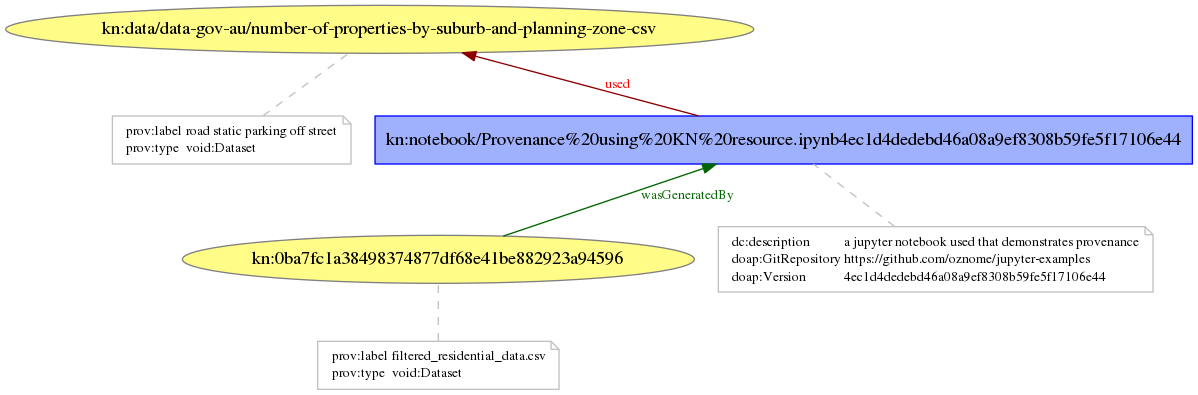

In [231]:
from IPython.display import Image
Image('prov.png')

## Posting to a Provenance Storage S